In [ ]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/

In [ ]:
!kaggle datasets download -d sachinkumar413/alzheimer-mri-dataset

alzheimer-mri-dataset.zip: Skipping, found more recently modified local copy (use --force to force download)


In [ ]:
import zipfile

zip_ref=zipfile.ZipFile('/content/alzheimer-mri-dataset.zip','r')
zip_ref.extractall('/content')
zip_ref.close()

In [ ]:
!pip install keras
!pip install tensorflow

In [ ]:
#Set up the environment and upload the data
from sklearn.preprocessing import StandardScaler
from  glob import glob
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.image as mpimg
from skimage.transform import resize
import pandas as pd
from matplotlib.image import imread
from skimage.io import imread_collection
from PIL import Image
import seaborn as sns
from sklearn import decomposition, preprocessing, svm
import sklearn.metrics as metrics #confusion_matrix, accuracy_score
from time import sleep
from tqdm.notebook import tqdm
import os
sns.set()

In [ ]:
#Dataset that should go with Alzheimer label
very_mild = glob(r'/content/Dataset/Very_Mild_Demented/*')
mild = glob(r'/content/Dataset/Mild_Demented/*')
moderate = glob(r'/content/Dataset/Moderate_Demented/*')

#Dataset without Alzheimer
non = glob(r'/content/Dataset/Non_Demented/*')

/content/Dataset/Non_Demented/non_2478.jpg
One of the data in Non Alzheimer Folder
Image shape:(128, 128)


array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=uint8)

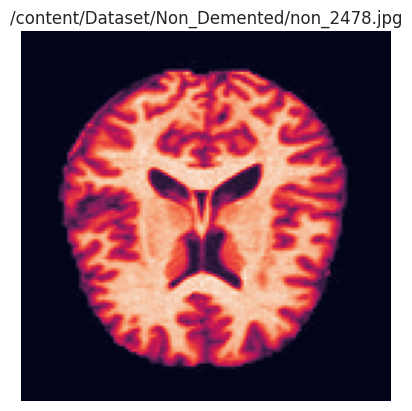

In [ ]:
print(non[2])
def view_image(directory):
    img = mpimg.imread(directory)
    plt.imshow(img)
    plt.title(directory)
    plt.axis('off')
    print(f'Image shape:{img.shape}')
    return img

print('One of the data in Non Alzheimer Folder')
view_image(non[2])

Resizing of data


In [ ]:
#List where arrays shall be stored
resized_image_array=[]
#List that will store the answer if an image is female (0) or male (1)
resized_image_array_label=[]

width = 256
height = 256
new_size = (width,height) #the data is just black to white

#Iterate over pictures and resize them to 256 by 256
def resizer(image_directory):
    for file in image_directory: #tried with os.listdir but could work with os.walk as well
        img = Image.open(file) #just putting image_directory or file does not work for google colab, interesting.
        #preserve aspect ratio
        img = img.resize(new_size)
        array_temp = np.array(img)
        shape_new = width*height
        img_wide = array_temp.reshape(1, shape_new)
        resized_image_array.append(img_wide[0])
        if image_directory == non:
            resized_image_array_label.append(0)
        else:
            resized_image_array_label.append(1)

ALZ = very_mild + mild + moderate
resizer(non)
resizer(ALZ)

In [ ]:
print(len(non))
print(len(ALZ)) #data are well transformed. Let's conduct SVM
print(len(resized_image_array))
print(resized_image_array[1])

#split the data to test and training
from sklearn.model_selection import train_test_split
train_x, test_x, train_y, test_y = train_test_split(resized_image_array, resized_image_array_label, test_size = 0.2)


3200
3200
6400
[0 0 0 ... 0 0 0]


feature extraction using GLCM

In [ ]:
from skimage.feature import greycomatrix, greycoprops

# define the distances and angles for the GLCM
distances = [1]
angles = [0]

# define the properties to compute from the GLCM
properties = ['energy', 'contrast', 'correlation', 'homogeneity', 'ASM']

# compute GLCM features for each image in the training set
train_glcm_features = []
for image in train_x:
    # compute the GLCM with the specified distances, angles, and levels
    glcm = greycomatrix(image.reshape((width, height)), distances=distances, angles=angles, levels=256, symmetric=True, normed=True)
    # compute the specified properties from the GLCM and append them to the feature vector
    features = [greycoprops(glcm, prop)[0][0] for prop in properties]
    train_glcm_features.append(features)

# compute GLCM features for each image in the test set
test_glcm_features = []
for image in test_x:
    # compute the GLCM with the specified distances, angles, and levels
    glcm = greycomatrix(image.reshape((width, height)), distances=distances, angles=angles, levels=256, symmetric=True, normed=True)
    # compute the specified properties from the GLCM and append them to the feature vector
    features = [greycoprops(glcm, prop)[0][0] for prop in properties]
    test_glcm_features.append(features)

Streaming output truncated to the last 5000 lines.
/usr/local/lib/python3.10/dist-packages/skimage/feature/__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
/usr/local/lib/python3.10/dist-packages/skimage/feature/__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
/usr/local/lib/python3.10/dist-packages/skimage/feature/__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
/usr/local/lib/python3.10/dist-packages/skimage/feature/__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0

In [ ]:
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score

# create an SVM classifier with a linear kernel
clf = SVC(kernel='linear')

# fit the classifier to the training data
clf.fit(train_glcm_features, train_y)

# make predictions on the test data
y_pred = clf.predict(test_glcm_features)

# compute the accuracy of the classifier
accuracy = accuracy_score(test_y, y_pred)

print("Accuracy:", accuracy)

Accuracy: 0.60078125


In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

# create a RF classifier with 100 trees
clf = RandomForestClassifier(n_estimators=100)

# fit the classifier to the training data
clf.fit(train_glcm_features, train_y)

# make predictions on the test data
y_pred = clf.predict(test_glcm_features)

# compute the accuracy of the classifier
accuracy = accuracy_score(test_y, y_pred)

print("Accuracy:", accuracy)

Accuracy: 0.70703125


In [ ]:
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestClassifier
clf = RandomForestClassifier()
# perform k-fold cross-validation (here k=5)
scores = cross_val_score(clf, train_glcm_features, train_y, cv=5)

# print the accuracy for each fold
print("Cross-validation scores:", scores)

# compute the mean and standard deviation of the accuracy across all folds
mean_accuracy = scores.mean()
std_accuracy = scores.std()

print("Mean accuracy:", mean_accuracy)
print("Standard deviation:", std_accuracy)

Cross-validation scores: [0.70996094 0.6796875  0.71875    0.69140625 0.70214844]
Mean accuracy: 0.700390625
Standard deviation: 0.01371922603815308


feature extraction using Gabor Filter

In [ ]:
# Define the parameters for the Gabor filter
ksize = 31  # size of the filter kernel
sigma = 4  # standard deviation of the Gaussian function used in the filter
theta = 0  # orientation of the filter
lambd = 10  # wavelength of the sinusoidal factor in the filter
gamma = 0.5  # spatial aspect ratio of the filter

# Create the Gabor filter
kernel = cv2.getGaborKernel((ksize, ksize), sigma, theta, lambd, gamma, 0, ktype=cv2.CV_32F)

# Apply the Gabor filter to each image
gabor_features_train = []
for img in train_x:
    # Convert the image from a 1D array to a 2D array
    img_2d = np.reshape(img, (height, width)).astype(np.float32)
    # Apply the Gabor filter to the image
    filtered_img = cv2.filter2D(img_2d, cv2.CV_8UC3, kernel)
    # Convert the filtered image back to a 1D array and add it to the feature list
    gabor_features_train.append(np.ravel(filtered_img))

gabor_features_test = []
for img in test_x:
    # Convert the image from a 1D array to a 2D array
    img_2d = np.reshape(img, (height, width)).astype(np.float32)
    # Apply the Gabor filter to the image
    filtered_img = cv2.filter2D(img_2d, cv2.CV_8UC3, kernel)
    # Convert the filtered image back to a 1D array and add it to the feature list
    gabor_features_test.append(np.ravel(filtered_img))


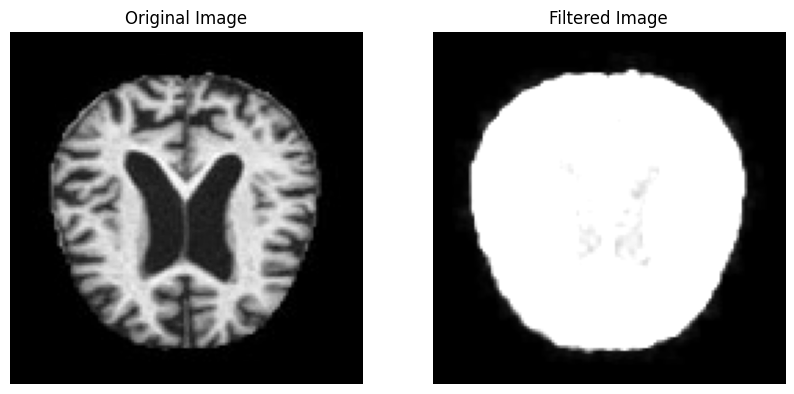

In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Load image
img = cv2.imread('/content/Dataset/Moderate_Demented/moderate.jpg', 0)

# Define parameters for Gabor filter
ksize = 3
sigma = 5
theta = 0
lamda = 10
gamma = 0.5
phi = 0

# Create Gabor filter
kernel = cv2.getGaborKernel((ksize, ksize), sigma, theta, lamda, gamma, phi, ktype=cv2.CV_32F)

# Apply Gabor filter to image
filtered_img = cv2.filter2D(img, cv2.CV_8UC3, kernel)

# Display original image and filtered image side by side
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
ax[0].imshow(img, cmap='gray')
ax[0].set_title('Original Image')
ax[0].axis('off')
ax[1].imshow(filtered_img, cmap='gray')
ax[1].set_title('Filtered Image')
ax[1].axis('off')
plt.show()



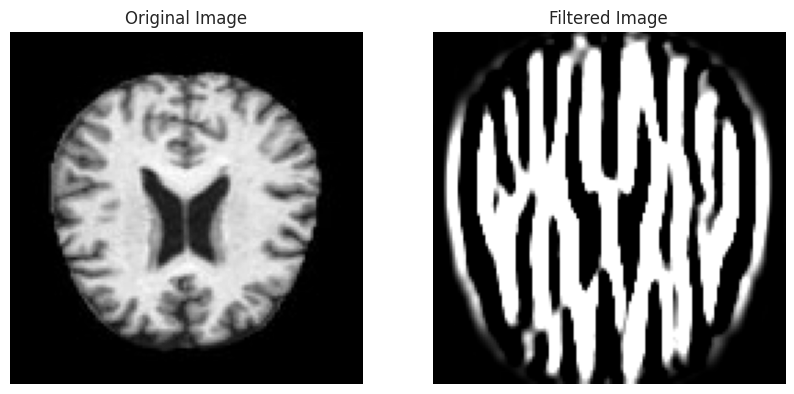

In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Load image
img = cv2.imread('/content/Dataset/Non_Demented/non.jpg', 0)

# Define parameters for Gabor filter
ksize = 31
sigma = 5
theta = 0
lamda = 10
gamma = 0.5
phi = 0

# Create Gabor filter
kernel = cv2.getGaborKernel((ksize, ksize), sigma, theta, lamda, gamma, phi, ktype=cv2.CV_32F)

# Apply Gabor filter to image
filtered_img = cv2.filter2D(img, cv2.CV_8UC3, kernel)

# Display original image and filtered image side by side
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
ax[0].imshow(img, cmap='gray')
ax[0].set_title('Original Image')
ax[0].axis('off')
ax[1].imshow(filtered_img, cmap='gray')
ax[1].set_title('Filtered Image')
ax[1].axis('off')
plt.show()



In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

# create a RF classifier with 100 trees
clf = RandomForestClassifier(n_estimators=100)

# fit the classifier to the training data
clf.fit(gabor_features_train, train_y)

# make predictions on the test data
y_pred = clf.predict(gabor_features_test)

# compute the accuracy of the classifier
accuracy = accuracy_score(test_y, y_pred)

print("Accuracy:", accuracy)

Accuracy: 0.928125


mean square error of RF

In [ ]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error

# create a Random Forest regressor
rf = RandomForestRegressor()

# fit the regressor to the training data
rf.fit(train_glcm_features, train_y)

# make predictions on the test data
y_pred = rf.predict(test_glcm_features)

# compute the mean squared error of the regressor
mse = mean_squared_error(test_y, y_pred)

print("Mean Squared Error:", mse)

Mean Squared Error: 0.189145078125
